# **Import Libraries**

In [0]:
%tensorflow_version 1.x

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
print(tf.__version__)

import keras as keras
import os, random
from PIL import Image
from matplotlib import pyplot
import numpy as np
from datetime import datetime
import pytz
from pytz import timezone
format = "%d-%m-%Y_%H-%M-%S"
from tqdm import tnrange



from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Add, Dropout, SeparableConv2D, SpatialDropout2D, DepthwiseConv2D, LocallyConnected1D
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras import metrics
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model
from keras.models import load_model

TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


# **Configuration**

In [0]:
class configuration():

  #enter the paths accordingly
  training_dir_path = "/content/drive/My Drive/Colab Notebooks/Facial Recognition/datasets/sc_dataset/training/"
  testing_dir_path = "/content/drive/My Drive/Colab Notebooks/Facial Recognition/datasets/sc_dataset/testing/"
  log_folder = "/content/drive/My Drive/Colab Notebooks/Facial Recognition/logs/"
  training_log_file_name = "training_log.txt"
  custom_test_dir = "/content/drive/My Drive/Colab Notebooks/Facial Recognition/datasets/custom_test_images/"

  image_size = int(200)  #input size for the model
  
  adam_lr = 0.0006
  contrastive_loss_margin = 1
  epoch = 10    # this is the default epoch number.        
  batch_size = 32
  test_trials = 10  # trails to perform while testing

# **Support Functions**

### Mount the google drive

In [0]:
def mount_drive():
  from google.colab import drive
  drive.mount('/content/drive')

  return

### get current data and time

In [0]:
def get_date_time():
  
  now_utc = datetime.now(timezone('UTC'))
  now = str(now_utc.astimezone(timezone('Asia/Kolkata')).strftime(format))

  return now

### log dir

In [0]:
def create_log_dir():
  
  """
  It creates a subfolder in the main log folder based on current date
  """
  
  log_dir_path = os.path.join(configuration.log_folder, (datetime.now().strftime("%d-%m-%Y")))
  if os.path.isdir(log_dir_path) == False :
    os.mkdir(log_dir_path)
    print(f"Folder {log_dir_path} created")
  else:
    print(f"Folder {log_dir_path} already exists")
  
  return log_dir_path

### check available gpu

In [0]:
def check_available_gpu():
  """
  Checks how much cpu and gpu is available
  """

  !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
  !pip install gputil
  !pip install psutil
  !pip install humanize

  import psutil
  import humanize
  import os
  import GPUtil as GPU
  GPUs = GPU.getGPUs()

  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()

  return None

# **Dataset Functions**

### view data

In [0]:
def view_data(img0_arr, img1_arr, tags):
  """
  plots the pairs and the tags
  """
  rows = 1
  columns = len(img0_arr)
  fig = pyplot.figure()

  for i in range(1, len(img0_arr)+1 ):
    fig.add_subplot(rows, columns, i)
    pyplot.imshow(np.squeeze(img0_arr[i-1]))
  pyplot.show()
  fig = pyplot.figure()
  for i in range(1, len(img1_arr)+1 ):
    fig.add_subplot(rows, columns, i)
    pyplot.imshow(np.squeeze(img1_arr[i-1]))
  pyplot.show()
  print(np.transpose(tags))

  return

### collect data

In [0]:
def collect_data(path, num_samples):
  """
  create pairs and tags 
  """

  tag = []
  img0_arr = []
  img1_arr = []
  #image_collected = 0
  for i in range(0,num_samples):

    pair_choice = random.randint(0,1)
    
    if pair_choice == 0:
      
      folder = (random.choice(os.listdir(path)))
      folder_path = os.path.join(path,folder)
      filename0 = random.choice(os.listdir(folder_path))
      img0_path = os.path.join(folder_path,filename0)
      filename1 = random.choice(os.listdir(folder_path))
      img1_path = os.path.join(folder_path,filename1)
    
    else:
      
      folder0 = (random.choice(os.listdir(path)))
      folder0_path = os.path.join(path,folder0)
      filename0 = random.choice(os.listdir(folder0_path))
      img0_path = os.path.join(folder0_path,filename0)
      
      while True:
        folder1 = (random.choice(os.listdir(path)))
        folder1_path = os.path.join(path,folder1)
        if folder0_path != folder1_path :
          break
      filename1 = random.choice(os.listdir(folder1_path))
      img1_path = os.path.join(folder1_path,filename1)
    
    img0 = Image.open(img0_path).convert('RGB')
    img0 = img0.resize((configuration.image_size,configuration.image_size))
    img0 = (np.asarray(img0, dtype=np.float32))/255.0
    img0_arr.append(img0)

    img1 = Image.open(img1_path).convert('RGB')
    img1 = img1.resize((configuration.image_size,configuration.image_size))
    img1 = (np.asarray(img1, dtype=np.float32))/255.0
    img1_arr.append(img1)

    tag.append(pair_choice)
  
  return img0_arr, img1_arr, tag

In [0]:
def get_images(img0_paths, img1_paths):
  
  img0_arr = []
  img1_arr = []

  def return_image(img_path):

    img = Image.open(img_path).convert('RGB')
    img = img.resize((configuration.image_size,configuration.image_size))
    img = (np.asarray(img, dtype=np.float32))/255.0
    
    return img
  
  for i in range(len(img0_paths)):  
    img0_arr.append( return_image(img0_paths[i]) )
    img1_arr.append( return_image(img1_paths[i]) )
  
  return img0_arr, img1_arr

def get_folder_list(path):
  folders = []

  for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    folders.append(folder_path)

  return folders

def get_image_pair_paths(folders):

  image1_paths = []
  image2_paths = []
  tags = []

  print("Generating image pair paths: ")
  for i in tnrange(len(folders)):
    current_folder_path = folders[i]
    for current_image_name in os.listdir(current_folder_path):
      choice = random.randint(0,1)
      if choice == 0:
        image1_paths.append(os.path.join(folders[i], current_image_name))
        image2_name = random.choice(os.listdir(folders[i]))
        image2_paths.append(os.path.join(folders[i], image2_name))
        tags.append(choice)
      
      else:
        folder1 = folders[i]
        while True:
          folder2 = random.choice(folders)
          if folder1 != folder2 :
            break
        
        image1_paths.append(os.path.join(folder1, current_image_name))
        image2_name = random.choice(os.listdir(folder2))
        image2_paths.append(os.path.join(folder2, image2_name))
        tags.append(choice)

  combined_zip = list(zip(image1_paths, image2_paths, tags))
  random.shuffle(combined_zip)
  image1_paths[:], image2_paths[:], tags[:] = zip(*combined_zip)

  return image1_paths, image2_paths, tags


# **Model Functions**

### euclidean distance

In [0]:
def euclidean_distance(vects):
  """
  calculate the euclidean distance between the encodings
  """
  x, y = vects

  dist = K.minimum( (K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))), 1.0)

  return dist

### contrative loss

In [0]:
def contrastive_loss(y_true, y_pred):
  """
  contrastive loss function
  """

  margin = configuration.contrastive_loss_margin
  similar_part = ( K.square(y_pred) / 2.0 )
  different_part = ( K.square( K.maximum( (margin - y_pred), 0 ) ) / 2.0 )
  diff = ( (1 - y_true) * similar_part ) + (y_true * different_part)

  return diff

### plot model

In [0]:
def plot_network_model(model, filename):
  """
  function to plot the network model
  """
  
  filename = os.path.join(create_log_dir(), filename)
  plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

  return

### compile model

In [0]:
def compile_network_model(model):
  """
  compiling the network model
  """

  print("Compiling Model")
  
  print("Learning rate:",configuration.adam_lr)
  optimizer = Adam(configuration.adam_lr)
  model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=['accuracy'])
  
  print("Successfully compiled")

  return model

### train model

In [0]:
def train_network_model(model, loss_history, acc_history, threshold_history):
  """
  train the network model
  """

  log_dir_path = create_log_dir()   #create a log directory in log folder based on current date

  log_file_name = str(configuration.training_log_file_name)
  log_file_path = os.path.join(log_dir_path, log_file_name)
  file = open(log_file_path,"a",encoding="utf-8")    # open the file for writing the results
  print(f"File {log_file_name} created")

  training_epoch = int(input("\nEnter the number of training epoch (-1 for default set epoch): "))   # ask for number of epochs
  if training_epoch == -1:
    training_epoch = configuration.epoch
  else:
    pass
  

  folders = get_folder_list(configuration.training_dir_path)
  print("Starting training process!")
  print("-------------------------------------")
  print("Iterating over epochs: ")
  for i in tnrange(1, training_epoch+1):

    img0_paths, img1_paths, tags = get_image_pair_paths(folders)
    total_batches = int(len(tags)/configuration.batch_size)
    batch_no = 0
    print("Iterating over batches: ")
    for j in tnrange(0, len(tags), configuration.batch_size):
      
      img0, img1 = get_images(img0_paths[j: j+configuration.batch_size], img1_paths[j: j+configuration.batch_size])

      batch_no = batch_no + 1
      
      loss = model.train_on_batch([img0, img1], [tags[j: j+configuration.batch_size], tags[j: j+configuration.batch_size]] )
      current_dynamic_threshold = dynamic_threshold.calculate_dynamic_threshold(model)
      loss_history.append(loss[0])
      acc_history.append(loss[1])
      threshold_history.append(current_dynamic_threshold)
      file.write(f"\nEpoch: {i} | Batch no: {batch_no}/{total_batches+1} | Loss: {loss} | Current Threshold: {current_dynamic_threshold}")
      print(f"Epoch: {i} | Batch no: {batch_no}/{total_batches+1} | Loss: {loss} | Current Threshold: {current_dynamic_threshold}")

    file.write(f"\n")
    print("\n")
  
  file.close()

  #plot the values
  
  pyplot.plot(loss_history)
  pyplot.grid(b=True, which='major', color='#858585', linestyle='-')
  pyplot.minorticks_on()
  pyplot.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.7)
  pyplot.title('Loss History')
  pyplot.xlabel(f'Iterations (Batch Size = {configuration.batch_size})')
  pyplot.ylabel('Loss')
  pyplot.savefig(os.path.join(os.path.join(configuration.log_folder, (datetime.now().strftime("%d-%m-%Y"))), "training_loss_history.png"))
  pyplot.show()

  pyplot.plot(acc_history)
  pyplot.grid(b=True, which='major', color='#858585', linestyle='-')
  pyplot.minorticks_on()
  pyplot.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.7)
  pyplot.title('Accuracy History')
  pyplot.xlabel(f'Iterations (Batch Size = {configuration.batch_size})')
  pyplot.ylabel('Accuracy')
  pyplot.savefig(os.path.join(os.path.join(configuration.log_folder, (datetime.now().strftime("%d-%m-%Y"))), "training_acc_history.png"))
  pyplot.show()

  pyplot.plot(threshold_history)
  pyplot.grid(b=True, which='major', color='#858585', linestyle='-')
  pyplot.minorticks_on()
  pyplot.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.7)
  pyplot.title('Threshold History')
  pyplot.xlabel(f'Iterations (Batch Size = {configuration.batch_size})')
  pyplot.ylabel('Threshold')
  pyplot.savefig(os.path.join(os.path.join(configuration.log_folder, (datetime.now().strftime("%d-%m-%Y"))), "training_threshold_history.png"))
  pyplot.show()

  return model, loss_history, acc_history, threshold_history, current_dynamic_threshold

### test model

In [0]:
def test_network_model(model, current_dynamic_threshold):
  """
  test the trained model
  """

  testing_acc = []

  folders = get_folder_list(configuration.testing_dir_path)
  print("Starting testing process!")
  print("-------------------------------------")
  testing_start_time = get_date_time()

  img0_paths, img1_paths, tags = get_image_pair_paths(folders)
    
  total_batches = int(len(tags)/configuration.batch_size)
  batch_no = 0
    
  for j in tnrange(0, len(tags), configuration.batch_size):
      
    img0, img1 = get_images(img0_paths[j: j+configuration.batch_size], img1_paths[j: j+configuration.batch_size])
    batch_no = batch_no + 1
    
    predictions = model.predict([img0,img1])

    #as the model has two outputs (1st auxiliary output, 2nd final output), we are using the final output. So pass predictions[1]
    testing_acc.append(calc_accuracy(tags[j: j+configuration.batch_size], predictions[1], current_dynamic_threshold))
  
  testing_end_time = get_date_time()
    
  model_accuracy = np.mean(testing_acc)
  print("*"*30)
  print(f"Accuracy: {model_accuracy}")
  print(f"Testing started at : {testing_start_time} | Testing ended at {testing_end_time}")
  print("*"*30)

  return model_accuracy

### save model

In [0]:
def save_network_model(model, current_threshold, name):
  
  """
  returns the path of the saved model
  """
  
  model_name = str(name) + str("_") + get_date_time() + str(f'_thres_{current_threshold}_')+str(".h5")
  model_path = os.path.join(create_log_dir(), model_name)
  model.save(model_path)

  return model_path

### load model

In [0]:
def load_network_model(model_path):
  """
  loads the pre trained model
  """
  # load model
  loaded_model = load_model(model_path, compile = False)
  
  # summarize model.
  loaded_model.summary()

  return loaded_model

# **Model**

In [0]:
def convolutional_model_multi(input_shape):
  conv_input = Input(shape = input_shape)

  x1 = SeparableConv2D(32, (5,5), strides=(3, 3), padding='valid', depth_multiplier=1, activation='relu', input_shape = input_shape)(conv_input)
  x1 = BatchNormalization()(x1)
  
  x1 = SeparableConv2D(64, (3,3), strides=(2, 2), padding='valid', depth_multiplier=1, activation='relu')(x1) 
  x1 = SeparableConv2D(64, (3,3), strides=(2, 2), padding='valid', depth_multiplier=1, activation='relu')(x1)
  x1 = BatchNormalization()(x1)

  x1 = SeparableConv2D(64, (2,2), strides=(2, 2), padding='valid', depth_multiplier=1, activation='relu')(x1)
  x1 = SeparableConv2D(64, (2,2), strides=(2, 2), padding='valid', depth_multiplier=1, activation='relu')(x1)
  conv_output = BatchNormalization()(x1)

  conv_part = Model(inputs=[conv_input],outputs=[conv_output])
  
  print("*"*10,"Convolutional Sub Part","*",10)
  conv_part.summary()
  print("*"*30)
  
  return conv_part


def convolutional_nn_multi(input_shape):

  conv_input = Input(shape = input_shape)

  conv_nn1 = convolutional_model_multi(input_shape)
  conv_nn2 = convolutional_model_multi(input_shape)
  conv_nn3 = convolutional_model_multi(input_shape)
  conv_nn4 = convolutional_model_multi(input_shape)
  conv_nn5 = convolutional_model_multi(input_shape)
  conv_nn6 = convolutional_model_multi(input_shape)
  conv_nn7 = convolutional_model_multi(input_shape)
  conv_nn8 = convolutional_model_multi(input_shape)

  conv_1_out = conv_nn1(conv_input)
  conv_2_out = conv_nn2(conv_input)
  conv_3_out = conv_nn3(conv_input)
  conv_4_out = conv_nn4(conv_input)
  conv_5_out = conv_nn5(conv_input)
  conv_6_out = conv_nn6(conv_input)
  conv_7_out = conv_nn7(conv_input)
  conv_8_out = conv_nn8(conv_input)
  
  concat = concatenate([conv_1_out, conv_2_out, conv_3_out, conv_4_out, conv_5_out, conv_6_out, conv_7_out, conv_8_out])
  
  x2 = Flatten()(concat)
  x2 = Dropout(rate = 0.01)(x2)
  signal_fc_output = Dense(16, activation='relu', name = 'signal')(x2)
  
  spatial = SpatialDropout2D(rate = 0.01)(concat)

  x1 = Flatten()(spatial)
  x1 = Dropout(rate = 0.01)(x1)
  x1 = Dense(256, activation='relu')(x1)
  conv_output = Dense(128, activation='relu', name = 'encoded')(x1)

  conv_part = Model(inputs=[conv_input],outputs=[signal_fc_output, conv_output])
  
  print("*"*10,"Convolutional multi model Part","*",10)
  conv_part.summary()
  print("*"*30)
  
  return conv_part


def siamese_network_multi(input_shape):
    
  first_input = Input(input_shape)
  second_input = Input(input_shape)
  
  conv_nn = convolutional_nn_multi(input_shape)

  encoded_first_a = (conv_nn(first_input)[1])
  encoded_second_a = (conv_nn(second_input)[1])

  encoded_first_sig = (conv_nn(first_input)[0])
  encoded_second_sig = (conv_nn(second_input)[0])

  distance_a = Lambda(euclidean_distance)([encoded_first_a, encoded_second_a])
  distance_sig = Lambda(euclidean_distance)([encoded_first_sig, encoded_second_sig])
  
  siamese_net = Model(inputs=[first_input,second_input],outputs=[distance_sig, distance_a])

  print("*"*10,"Siamese Network","*",10)
  siamese_net.summary()
  print("*"*30)
  
  plot_network_model(siamese_net, "siamese_network_multi.png")

  return siamese_net


# **Assessment Functions**

### calculating accuracy

In [0]:
def calc_accuracy(tag, prediction, threshold):
  """
  returns the accuracy score
  """
  
  correct_classify = 0
  for i in range(0,len(tag)):
    if prediction[i] >= threshold:
      prediction[i] = 1
    else:
      prediction[i] = 0
    if prediction[i] == tag[i]:
      correct_classify = correct_classify + 1
  accuracy = (correct_classify * 100)/(len(tag))

  return accuracy

### calculating threshold

In [0]:
class dynamic_threshold():
  """
  calculating the threshold while training
  """

  count_0 = count_1 = 0
  sum_0 = sum_1 = 0

  def calculate_dynamic_threshold(model):

    img0, img1, tag = collect_data(configuration.testing_dir_path, 20)
    prediction = model.predict([img0, img1])[1]

    #stats = []

    for i in range(0, len(tag)):
      if tag[i] == 0 :
        dynamic_threshold.count_0 = dynamic_threshold.count_0 + 1
        dynamic_threshold.sum_0 = dynamic_threshold.sum_0 + prediction[i]
      else:
        dynamic_threshold.count_1 = dynamic_threshold.count_1 + 1
        dynamic_threshold.sum_1 = dynamic_threshold.sum_1 + prediction[i] 
    
    if dynamic_threshold.count_0 == 0:
      mean_0 = 0
    else:
      mean_0 = dynamic_threshold.sum_0 / dynamic_threshold.count_0
    
    if dynamic_threshold.count_1 == 0:
      mean_1 = 0
    else:
      mean_1 = dynamic_threshold.sum_1 / dynamic_threshold.count_1

    current_dynamic_threshold = np.sqrt( (np.square(mean_0) + np.square(mean_1)) / 2.0 )

    return current_dynamic_threshold #, stats

### test custom images

In [0]:
def custom_image_testing(model, filename0, filename1, threshold):
  """
  function to test custom images kept in custom_test_images
  
  """
  
  custom_test_dir_path = configuration.custom_test_dir

  img0_path = os.path.join(custom_test_dir_path, filename0)
  img1_path = os.path.join(custom_test_dir_path, filename1)

  img0_arr = []
  img1_arr = []

  img0 = Image.open(img0_path)
  img0 = img0.resize((configuration.image_size,configuration.image_size))
  img0 = (np.asarray(img0, dtype=np.float32))/255.0
  img0_arr.append(img0)
  pyplot.imshow(np.squeeze(img0))
  pyplot.show()

  img1 = Image.open(img1_path)
  img1 = img1.resize((configuration.image_size,configuration.image_size))
  img1 = (np.asarray(img1, dtype=np.float32))/255.0
  img1_arr.append(img1)
  pyplot.imshow(np.squeeze(img1))
  pyplot.show()

  prediction = model.predict([img0_arr, img1_arr])
  
  print("*"*30)
  print("Prediction Threshold: ", ((threshold)*100.0))
  print("Predicted value:",(prediction[1]*100.0))
  print("Match threshold: ", ((1-threshold)*100.0))
  if prediction[1] > 1.0 :
    print("Match = 0%")
    print("Different")
  else :
    match = (1.0 - prediction[1])*100
    print(f"Match = {match}%")
    if prediction[1] > threshold :
      print("Different")
    else :
      print("Same")
  print("*"*30)
  
  return


# **Driver Code**

### view pairs from dataset

Gen RAM Free: 12.6 GB  | Proc size: 424.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Facial Recognition/datasets/sc_dataset/training/
/content/drive/My Drive/Colab Notebooks/Facial Recognition/datasets/sc_dataset/testing/
>> Path Set


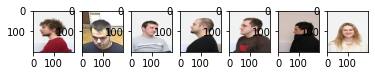

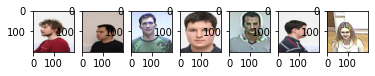

[0 0 1 1 1 1 0]
(200, 200, 3)


In [0]:
check_available_gpu()

mount_drive()

print(configuration.training_dir_path)
print(configuration.testing_dir_path)
print(">> Path Set")

print("Collecting Sample Data: ")

img0, img1, tag = collect_data(configuration.training_dir_path,7)

view_data(img0,img1,tag)

img = np.stack(img0)
print(img0[0].shape)

### compile and print the summary of the model

In [0]:

print("Constructing Model")
model = siamese_network_multi(img0[0].shape)
model.summary()
print("Successfully constructed")

model = compile_network_model(model)

Constructing Model
********** Convolutional Sub Part * 10
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 200, 200, 3)       0         
_________________________________________________________________
separable_conv2d_161 (Separa (None, 66, 66, 32)        203       
_________________________________________________________________
batch_normalization_97 (Batc (None, 66, 66, 32)        128       
_________________________________________________________________
separable_conv2d_162 (Separa (None, 32, 32, 64)        2400      
_________________________________________________________________
separable_conv2d_163 (Separa (None, 15, 15, 64)        4736      
_________________________________________________________________
batch_normalization_98 (Batc (None, 15, 15, 64)        256       
_________________________________________________________________


### train

Folder /content/drive/My Drive/Colab Notebooks/Facial Recognition/logs/02-04-2020 already exists
File training_log_multi(final).txt created
Starting training process!
-------------------------------------
Iterating over epochs: 


Generating image pair paths: 



Iterating over batches: 


Epoch: 1/1 | Batch no: 1/172 | Loss: [0.27135077, 0.1453647, 0.12598607, 0.53125, 0.53125, 0.5625, 0.5625] | Current Threshold: [0.95547783]
Epoch: 1/1 | Batch no: 2/172 | Loss: [0.24519625, 0.11352384, 0.13167241, 0.625, 0.625, 0.46875, 0.46875] | Current Threshold: [0.94143456]
Epoch: 1/1 | Batch no: 3/172 | Loss: [0.25077385, 0.13195018, 0.11882365, 0.5625, 0.5625, 0.5625, 0.5625] | Current Threshold: [0.92632127]
Epoch: 1/1 | Batch no: 4/172 | Loss: [0.23090994, 0.12281263, 0.10809732, 0.5625, 0.5625, 0.59375, 0.59375] | Current Threshold: [0.91374135]
Epoch: 1/1 | Batch no: 5/172 | Loss: [0.26524764, 0.14078069, 0.12446697, 0.34375, 0.34375, 0.625, 0.625] | Current Threshold: [0.9023681]
Epoch: 1/1 | Batch no: 6/172 | Loss: [0.24863067, 0.12741669, 0.12121398, 0.53125, 0.53125, 0.59375, 0.59375] | Current Threshold: [0.89137346]
Epoch: 1/1 | Batch no: 7/172 | Loss: [0.21444693, 0.101081364, 0.113365576, 0.71875, 0.71875, 0.5625, 0.5625] | Current Threshold: [0.8820721]
Epoch: 1/1 

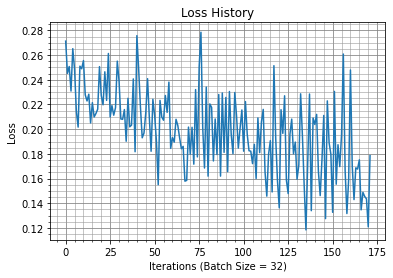

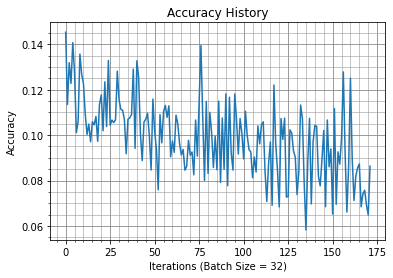

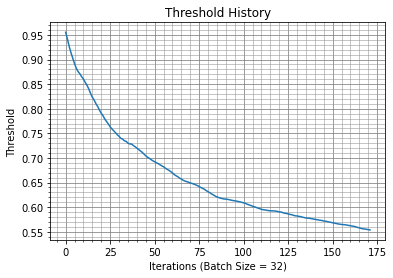

KeyboardInterrupt: ignored

In [0]:
loss_history = []
acc_history = []
threshold_history = []

training_start_time = get_date_time()

while True:
  
  model, loss_history, acc_history, threshold_history, current_dynamic_threshold = train_network_model(model, loss_history, acc_history, threshold_history)
  
  train_choice = str(input("Do you want to continue the training ? (y/n): "))
  if train_choice == 'y':
    continue
  elif train_choice == 'n':
    break

training_end_time = get_date_time()
print("Training Started at: ", training_start_time)
print("Training Ended at: ", training_end_time)


### test model

In [0]:
"""
testing the trained model
"""

test_network_model(model, current_dynamic_threshold)

### Save

In [0]:
"""
save the siamese model
"""

siamese_model_path = save_network_model(model, current_dynamic_threshold, name = 'siamese_network')
print(f"model saved at {siamese_model_path}")


Folder /content/drive/My Drive/Colab Notebooks/Facial Recognition/logs/02-04-2020 already exists
model saved at /content/drive/My Drive/Colab Notebooks/Facial Recognition/logs/02-04-2020/siamese_network_02-04-2020_15-51-29_thres_[0.5292735]_.h5
Folder /content/drive/My Drive/Colab Notebooks/Facial Recognition/logs/02-04-2020 already exists
model saved at /content/drive/My Drive/Colab Notebooks/Facial Recognition/logs/02-04-2020/conv_nn_02-04-2020_15-51-29_thres_[0.5292735]_.h5


### Load model

In [0]:
"""
load the saved model
"""

loaded_model = load_network_model(siamese_model_path)
print("Model loaded")


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
model_9 (Model)                 (None, 3, 3, 512)    74200       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_10 (Model)                (None, 128)          1212800     model_9[1][0]             

### Custom Test

In [0]:
"""
for testing custom images call:
custom_image_testing(loaded_model, filename0, filename1, threshold)
"""

custom_image_testing(loaded_model, "rv_1.jpg", "rv_2.jpg", current_dynamic_threshold)
custom_image_testing(loaded_model, "rv_1.jpg", "rv_g.jpg", current_dynamic_threshold)
custom_image_testing(loaded_model, "rv_2.jpg", "rv_5.jpg", current_dynamic_threshold)
custom_image_testing(loaded_model, "rv_5.jpg", "rv_7.jpg", current_dynamic_threshold)
custom_image_testing(loaded_model, "rv_1.jpg", "sm_1.jpg", current_dynamic_threshold)
custom_image_testing(loaded_model, "rv_5.jpg", "sm_2.jpg", current_dynamic_threshold)
custom_image_testing(loaded_model, "sm_2.jpg", "sm_1.jpg", current_dynamic_threshold)
custom_image_testing(loaded_model, "sm_g.jpg", "sm_2.jpg", current_dynamic_threshold)

Output hidden; open in https://colab.research.google.com to view.